In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import os
import warnings
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as mcolors

In [2]:
od_gdf = gpd.read_file(r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\flood-data-ecosystem-Odisha\Maps\od_ids-drr_shapefiles\odisha_block_final_reduced.geojson")
od_gdf

,block_lgd,dtname,dtcode11,block_name,object_id,geometry
0,03276,Anugul,384,ANUGUL,21-384-03276,"MULTIPOLYGON (((84.79010 20.58127, 84.80244 20..."
1,03277,Anugul,384,ATHMALLIK,21-384-03277,"POLYGON ((84.32141 20.85289, 84.33643 20.84237..."
2,03278,Anugul,384,BANARPAL,21-384-03278,"POLYGON ((85.03052 20.83493, 85.04053 20.83409..."
3,03279,Anugul,384,CHHENDIPADA,21-384-03279,"POLYGON ((84.78059 20.89691, 84.77766 20.89364..."
4,03280,Anugul,384,KANIHA,21-384-03280,"POLYGON ((84.96277 21.17580, 84.96867 21.17320..."
...,...,...,...,...,...,...
309,03585,Sundargarh,374,NUAGAON,21-374-03585,"POLYGON ((84.74924 22.41905, 84.74984 22.41400..."
310,03586,Sundargarh,374,RAJGANGPUR,21-374-03586,"POLYGON ((84.45176 22.18435, 84.45643 22.18673..."
311,03587,Sundargarh,374,SUBDEGA,21-374-03587,"POLYGON ((84.05082 22.13313, 84.05870 22.13526..."
312,03588,Sundargarh,374,SUNDARGARH,21-374-03588,"POLYGON ((84.02877 21.95288, 84.03424 21.94918..."


#### Mapping flood-hazard

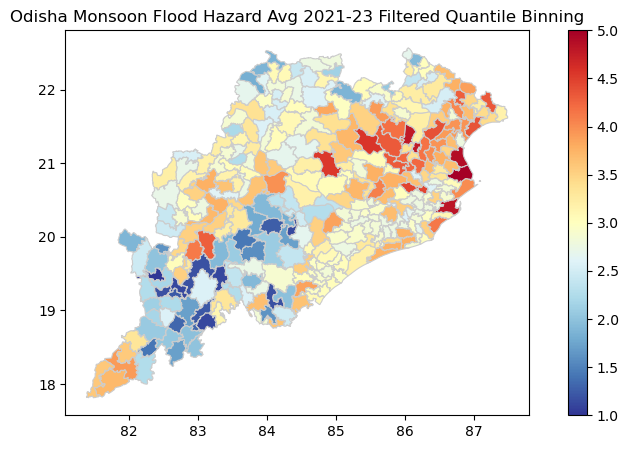

In [11]:
risk_score = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Odisha-Risk-Score-Model\data\risk_score.csv')

risk_score['month'] = risk_score['timeperiod'].str[-2:].astype(int)
risk_score_filtered = risk_score#[(risk_score['month'] >= 5) & (risk_score['month'] <= 9)]

# Calculate the average flood hazard level for May-September across all years
flood_avg = risk_score_filtered.groupby("object-id")["risk-score"].mean().reset_index()
flood_avg.rename(columns={"risk-score": "avg_flood_risk"}, inplace=True)


# Merge the data on 'object-id' column
od_gdf = od_gdf.rename(columns={"object_id": "object-id"})  # Ensure the column names match
merged_gdf = od_gdf.merge(flood_avg, on="object-id")

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])  # Adjust for position and size

# Plot the choropleth using the flood hazard level
merged_gdf.plot(column='avg_flood_risk',  # replace with the actual column for hazard data
                cmap='RdYlBu_r',  # choose a color map, e.g., OrRd for shades of red
                linewidth=0.8,
                ax=ax,
                edgecolor='0.8',
                legend=True)

# Add title and show the plot
plt.title("Odisha Monsoon Flood Hazard Avg 2021-23 Filtered Quantile Binning")
plt.show()


In [8]:
merged_gdf

,block_lgd,dtname,dtcode11,block_name,object-id,geometry,avg_flood_hazard
0,03276,Anugul,384,ANUGUL,21-384-03276,"MULTIPOLYGON (((84.79010 20.58127, 84.80244 20...",2.70
1,03277,Anugul,384,ATHMALLIK,21-384-03277,"POLYGON ((84.32141 20.85289, 84.33643 20.84237...",2.60
2,03278,Anugul,384,BANARPAL,21-384-03278,"POLYGON ((85.03052 20.83493, 85.04053 20.83409...",2.00
3,03279,Anugul,384,CHHENDIPADA,21-384-03279,"POLYGON ((84.78059 20.89691, 84.77766 20.89364...",2.10
4,03280,Anugul,384,KANIHA,21-384-03280,"POLYGON ((84.96277 21.17580, 84.96867 21.17320...",2.00
...,...,...,...,...,...,...,...
309,03585,Sundargarh,374,NUAGAON,21-374-03585,"POLYGON ((84.74924 22.41905, 84.74984 22.41400...",2.15
310,03586,Sundargarh,374,RAJGANGPUR,21-374-03586,"POLYGON ((84.45176 22.18435, 84.45643 22.18673...",2.25
311,03587,Sundargarh,374,SUBDEGA,21-374-03587,"POLYGON ((84.05082 22.13313, 84.05870 22.13526...",2.05
312,03588,Sundargarh,374,SUNDARGARH,21-374-03588,"POLYGON ((84.02877 21.95288, 84.03424 21.94918...",2.05


In [24]:
# Calculate the center for map display
center = [merged_gdf.geometry.centroid.y.mean(), merged_gdf.geometry.centroid.x.mean()]

# Initialize the folium map
m = folium.Map(location=center, zoom_start=7)

# Add the GeoDataFrame as a choropleth layer
folium.Choropleth(
    geo_data=merged_gdf.to_json(),
    name="choropleth",
    data=merged_gdf,
    columns=["object_id", "flood-hazard"],  # replace with hazard level column
    key_on="feature.properties.object_id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Flood Hazard Level"
).add_to(m)

# Add layer control and display map
folium.LayerControl().add_to(m)
m.save("assam_flood_hazard_map.html")


#### Log Quantile Binning

In [12]:
# Method 2: Log Transformation with Quantile Binning

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load data
master_variables = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\RiskScoreModel\data\MASTER_VARIABLES.csv')
hazard_vars = ['inundation_intensity_mean_nonzero', 'inundation_intensity_sum', 'drainage_density', 'mean_rain', 'max_rain']
hazard_df = master_variables[hazard_vars + ['timeperiod', 'object_id']]
hazard_df_months = []

# Define categories for hazard levels
categories = [1, 2, 3, 4, 5]


# Method 2: Log Transformation with Quantile Binning
def log_quantile_binning(df, var):
    # Add a small constant to avoid log(0)
    log_var = np.log1p(df[var])
    return pd.qcut(log_var, q=5, labels=categories, duplicates='drop')

hazard_df_months = []

# Processing monthly data
for month in tqdm(hazard_df.timeperiod.unique()):
    hazard_df_month = hazard_df[hazard_df.timeperiod == month]

    # Apply log transformation with quantile binning
    hazard_df_month['drainage_density_custom'] = log_quantile_binning(hazard_df_month, 'drainage_density')
    hazard_df_month['mean_rain_custom'] = log_quantile_binning(hazard_df_month, 'mean_rain')
    hazard_df_month['max_rain_custom'] = log_quantile_binning(hazard_df_month, 'max_rain')
    hazard_df_month['inundation_intensity_mean_nonzero_custom'] = custom_binning(hazard_df_month, 'inundation_intensity_mean_nonzero')
    hazard_df_month['inundation_intensity_sum_custom'] = custom_binning(hazard_df_month, 'inundation_intensity_sum')
    
    # Average hazard score
    hazard_df_month['flood-hazard'] = (hazard_df_month[['drainage_density_custom', 'mean_rain_custom', 
                                                        'max_rain_custom', 'inundation_intensity_mean_nonzero_custom',
                                                        'inundation_intensity_sum_custom']]
                                       .astype(float).mean(axis=1))
    hazard_df_months.append(hazard_df_month)

# Compile results
hazard = pd.concat(hazard_df_months)
master_variables = master_variables.merge(hazard[['timeperiod', 'object_id', 'flood-hazard']], on=['timeperiod', 'object_id'])

# Save the final results
master_variables.to_csv(os.getcwd() + r'/hazard_quantile-binning.csv', index=False)


 17%|█▋        | 7/42 [00:00<00:00, 84.58it/s]


ValueError: Bin labels must be one fewer than the number of bin edges

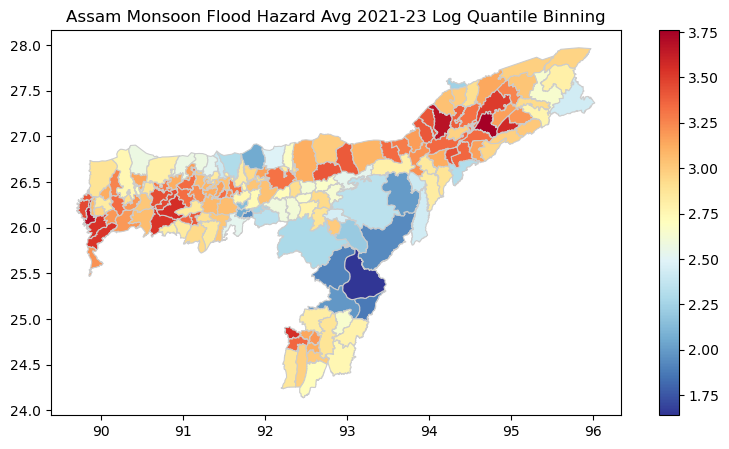

In [57]:
master_variables['month'] = master_variables['timeperiod'].str[-2:].astype(int)
master_variables_filtered = master_variables[(master_variables['month'] >= 5) & (master_variables['month'] <= 9)]

# Calculate the average flood hazard level for May-September across all years
flood_avg = master_variables_filtered.groupby("object_id")["flood-hazard"].mean().reset_index()
flood_avg.rename(columns={"flood-hazard": "avg_flood_hazard"}, inplace=True)


# Merge the data on 'object-id' column
merged_gdf = assam_gdf.merge(flood_avg, on="object_id")

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])  # Adjust for position and size

# Plot the choropleth using the flood hazard level
merged_gdf.plot(column='avg_flood_hazard',  # replace with the actual column for hazard data
                cmap='RdYlBu_r',  # choose a color map, e.g., OrRd for shades of red
                linewidth=0.8,
                ax=ax,
                edgecolor='0.8',
                legend=True)

# Add title and show the plot
plt.title("Assam Monsoon Flood Hazard Avg 2021-23 Log Quantile Binning")
plt.show()


#### Min-Max binning

In [3]:

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load data
master_variables = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\RiskScoreModel\data\MASTER_VARIABLES.csv')
hazard_vars = ['inundation_intensity_mean_nonzero', 'inundation_intensity_sum', 'drainage_density', 'mean_rain', 'max_rain']
hazard_df = master_variables[hazard_vars + ['timeperiod', 'object_id']]
hazard_df_months = []

# Define categories for hazard levels
categories = [1, 2, 3, 4, 5]

# Method 3: Non-Linear Scaling with MinMax or Robust Scalers
def scaled_binning(df, var, method='robust'):
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    scaled_values = scaler.fit_transform(df[[var]])
    return pd.cut(scaled_values.flatten(), bins=5, labels=categories)

hazard_df_months = []


# Processing monthly data
for month in tqdm(hazard_df.timeperiod.unique()):
    hazard_df_month = hazard_df[hazard_df.timeperiod == month]

    # Apply non-linear scaling with MinMax or Robust Scalers
    hazard_df_month['drainage_density_custom'] = scaled_binning(hazard_df_month, 'drainage_density', method='minmax')
    hazard_df_month['mean_rain_custom'] = scaled_binning(hazard_df_month, 'mean_rain', method='minmax')
    hazard_df_month['max_rain_custom'] = scaled_binning(hazard_df_month, 'max_rain',method='minmax')
    hazard_df_month['inundation_intensity_mean_nonzero_custom'] = scaled_binning(hazard_df_month, 'inundation_intensity_mean_nonzero',method='minmax')
    hazard_df_month['inundation_intensity_sum_custom'] = scaled_binning(hazard_df_month, 'inundation_intensity_sum',method='minmax')
    
    
    # Average hazard score
    hazard_df_month['flood-hazard'] = (hazard_df_month[['drainage_density_custom', 'mean_rain_custom', 
                                                        'max_rain_custom', 'inundation_intensity_mean_nonzero_custom',
                                                        'inundation_intensity_sum_custom']]
                                       .astype(float).mean(axis=1))
    hazard_df_months.append(hazard_df_month)

# Compile results
hazard = pd.concat(hazard_df_months)
master_variables = master_variables.merge(hazard[['timeperiod', 'object_id', 'flood-hazard']], on=['timeperiod', 'object_id'])

# Save the final results
master_variables.to_csv(os.getcwd() + r'/hazard_minmax-binning.csv', index=False)


100%|██████████| 42/42 [00:00<00:00, 102.72it/s]


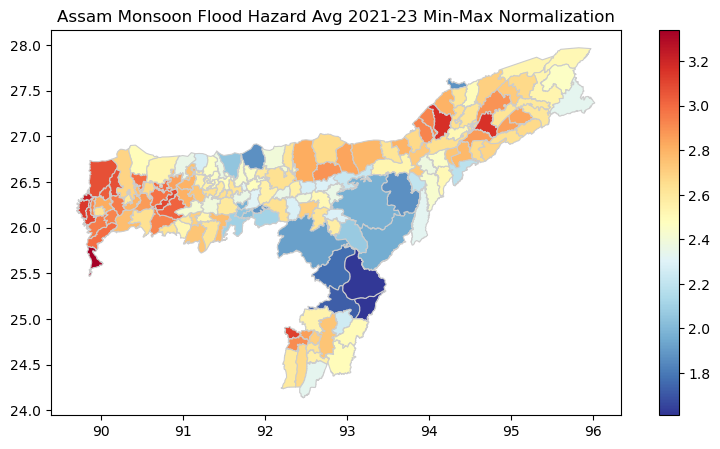

In [8]:
master_variables['month'] = master_variables['timeperiod'].str[-2:].astype(int)
master_variables_filtered = master_variables[(master_variables['month'] >= 5) & (master_variables['month'] <= 9)]

# Calculate the average flood hazard level for May-September across all years
flood_avg = master_variables_filtered.groupby("object_id")["flood-hazard"].mean().reset_index()
flood_avg.rename(columns={"flood-hazard": "avg_flood_hazard"}, inplace=True)


# Merge the data on 'object-id' column
merged_gdf = assam_gdf.merge(flood_avg, on="object_id")

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])  # Adjust for position and size

# Plot the choropleth using the flood hazard level
merged_gdf.plot(column='avg_flood_hazard',  # replace with the actual column for hazard data
                cmap='RdYlBu_r',  # choose a color map, e.g., OrRd for shades of red
                linewidth=0.8,
                ax=ax,
                edgecolor='0.8',
                legend=True)

# Add title and show the plot
plt.title("Assam Monsoon Flood Hazard Avg 2021-23 Min-Max Normalization")
plt.show()


In [75]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


# Suppress all warnings
warnings.filterwarnings("ignore")

# Load data
master_variables = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\RiskScoreModel\data\MASTER_VARIABLES.csv')
hazard_vars = ['inundation_intensity_mean_nonzero', 'inundation_intensity_sum', 'drainage_density', 'mean_rain', 'max_rain']
hazard_df = master_variables[hazard_vars + ['timeperiod', 'object_id']]
hazard_df_months = []


# Define the KMeans clustering function for hazard scoring
def kmeans_scoring(df, n_clusters=5):
    # Select relevant features for clustering
    features = ['drainage_density', 'inundation_intensity_sum', 
                'inundation_intensity_mean_nonzero', 'mean_rain', 'max_rain']
    
    # Normalize features to standardize their influence
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['kmeans_cluster'] = kmeans.fit_predict(X)
    
    # Calculate mean hazard intensity for each cluster
    cluster_means = df.groupby('kmeans_cluster')['inundation_intensity_sum'].mean()
    
    # Sort clusters by hazard intensity in descending order (highest hazard first)
    cluster_sorted = cluster_means.sort_values(ascending=False)
    
    # Create an inverted mapping from cluster label to hazard level
    inverse_levels = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}  # Mapping for inversion
    cluster_map = {cluster: inverse_levels[rank + 1] for rank, cluster in enumerate(cluster_sorted.index)}
    print("Inverted cluster mapping:", cluster_map)  # Debugging line
    
    # Map clusters to inverted hazard levels
    df['kmeans_hazard_level'] = df['kmeans_cluster'].map(cluster_map)
    
    # Final verification
    print("Assigned inverted hazard levels by cluster:")
    print(df[['kmeans_cluster', 'kmeans_hazard_level']].drop_duplicates().sort_values(by='kmeans_cluster'))
    
    return df['kmeans_hazard_level']

# Prepare monthly data
hazard_df_months = []

for month in tqdm(hazard_df.timeperiod.unique()):
    # Filter data for each month
    hazard_df_month = hazard_df[hazard_df.timeperiod == month]

    # Apply KMeans clustering for hazard scoring
    hazard_df_month['kmeans_hazard_level'] = kmeans_scoring(hazard_df_month)

    # Aggregate the results in a list
    hazard_df_months.append(hazard_df_month)

# Compile results
hazard = pd.concat(hazard_df_months)
master_variables = master_variables.merge(hazard[['timeperiod', 'object_id', 'kmeans_hazard_level']], on=['timeperiod', 'object_id'])

# Save the final results
master_variables.to_csv(os.getcwd() + r'/hazard_k-means.csv', index=False)

 33%|███▎      | 14/42 [00:00<00:00, 132.59it/s]

Inverted cluster mapping: {0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
Assigned inverted hazard levels by cluster:
      kmeans_cluster  kmeans_hazard_level
1134               0                    5
42                 1                    4
2016               2                    3
966                3                    2
0                  4                    1
Inverted cluster mapping: {0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
Assigned inverted hazard levels by cluster:
      kmeans_cluster  kmeans_hazard_level
1555               0                    5
43                 1                    4
1                  2                    3
6469               3                    2
127                4                    1
Inverted cluster mapping: {2: 5, 0: 4, 1: 3, 3: 2, 4: 1}
Assigned inverted hazard levels by cluster:
      kmeans_cluster  kmeans_hazard_level
884                0                    4
2                  1                    3
2690               2                    5
1136               3     

100%|██████████| 42/42 [00:00<00:00, 127.51it/s]

Inverted cluster mapping: {3: 5, 1: 4, 2: 3, 0: 2, 4: 1}
Assigned inverted hazard levels by cluster:
      kmeans_cluster  kmeans_hazard_level
1160               0                    2
656                1                    4
782                2                    3
950                3                    5
26                 4                    1
Inverted cluster mapping: {0: 5, 2: 4, 4: 3, 3: 2, 1: 1}
Assigned inverted hazard levels by cluster:
     kmeans_cluster  kmeans_hazard_level
111               0                    5
69                1                    1
195               2                    4
237               3                    2
27                4                    3
Inverted cluster mapping: {4: 5, 0: 4, 1: 3, 2: 2, 3: 1}
Assigned inverted hazard levels by cluster:
     kmeans_cluster  kmeans_hazard_level
322               0                    4
28                1                    3
112               2                    2
196               3                

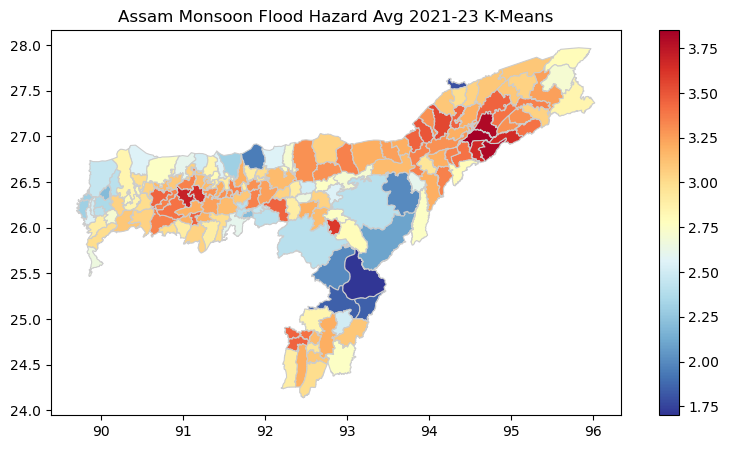

In [76]:
master_variables['month'] = master_variables['timeperiod'].str[-2:].astype(int)
master_variables_filtered = master_variables[(master_variables['month'] >= 5) & (master_variables['month'] <= 9)]

# Calculate the average flood hazard level for May-September across all years
flood_avg = master_variables_filtered.groupby("object_id")["kmeans_hazard_level"].mean().reset_index()
flood_avg.rename(columns={"kmeans_hazard_level": "avg_flood_hazard"}, inplace=True)


# Merge the data on 'object-id' column
merged_gdf = assam_gdf.merge(flood_avg, on="object_id")

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])  # Adjust for position and size

# Plot the choropleth using the flood hazard level
merged_gdf.plot(column='avg_flood_hazard',  # replace with the actual column for hazard data
                cmap='RdYlBu_r',  # choose a color map, e.g., OrRd for shades of red
                linewidth=0.8,
                ax=ax,
                edgecolor='0.8',
                legend=True)

# Add title and show the plot
plt.title("Assam Monsoon Flood Hazard Avg 2021-23 K-Means")
plt.show()
